# Colaborative recommendation using surprise library

- This notebook gives a basic glimps of how we can create recommendation system using surprise library.
I will try to elaborate each steps and will include the learning resources to understand the algorithm that we are going to use.

- The "Surprise" library is a Python library designed for building and analyzing recommender systems. It's specifically focused on collaborative filtering, which is a technique used in recommendation systems to make automatic predictions (filtering) about the interests of a user by collecting preferences from many users (collaborating).

- The Surprise library provides a range of algorithms and tools to make it easier to work with recommendation systems. It supports both explicit and implicit feedback data and offers various collaborative filtering algorithms such as Singular Value Decomposition (SVD), K-Nearest Neighbors (KNN), and more. The library also provides tools for evaluating and comparing the performance of different recommendation algorithms.

# Dataset

We will be using movielens dataset.

Dataset URL : https://www.kaggle.com/datasets/shubhammehta21/movie-lens-small-latest-dataset

In [1]:
# we can directly import dataset from surprise library
from surprise import Dataset

dataset = Dataset.load_builtin('ml-100k')
dataset

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Dataset ml-100k could not be found. Do you want to download it? [Y/n] n


But for now we will be downloading it from kaggle and will do some EDA.

## (Exploratory Data Analysis) EDA

Let's understand the movieLens dataset.

In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# checking path
!ls ../dataset/movieLens-sm

links.csv  movies.csv  ratings.csv  README.txt	tags.csv


So we have 4 separate csv files, namely links, movies, ratings, and tags. Let's check out each files.

In [3]:
# path config
BASE_PATH = "../dataset/movieLens-sm/"
RATING_PATH = os.path.join(BASE_PATH, "ratings.csv")
MOVIE_PATH = os.path.join(BASE_PATH, "movies.csv")
LINKS_PATH = os.path.join(BASE_PATH, "links.csv")
TAGS_PATH = os.path.join(BASE_PATH, "tags.csv")

In [4]:
# read links.csv
links_df = pd.read_csv(LINKS_PATH)
links_df.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


As you can see, links.csv file contains corresponding movie_id in IMDB and TMDB.

- movieId is an identifier for movies used by <https://movielens.org>. E.g., the movie Toy Story has the link <https://movielens.org/movies/1>.

- imdbId is an identifier for movies used by <http://www.imdb.com>. E.g., the movie Toy Story has the link <http://www.imdb.com/title/tt0114709/>.

- tmdbId is an identifier for movies used by <https://www.themoviedb.org>. E.g., the movie Toy Story has the link <https://www.themoviedb.org/movie/862>.


In [5]:
# read tags.csv
tags_df = pd.read_csv(TAGS_PATH)
tags_df.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


- Tags are user-generated metadata about movies. Each tag is typically a single word or short phrase. The meaning, value, and purpose of a particular tag is determined by each user.

- Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

In [191]:
# reading ratings.csv
ratings_df = pd.read_csv(RATING_PATH)
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [192]:
ratings_df[ratings_df["movieId"]==2851]

,userId,movieId,rating,timestamp
282,3,2851,5.0,1306463925
31391,217,2851,3.0,955942393
42665,288,2851,2.0,1020369199
72810,469,2851,3.0,965335989


- Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars). Timestamps represent seconds since midnight Coordinated Universal Time (UTC) of January 1, 1970.

**Note: This is the data we are going to use to build collaborative recommendation system. This gives information about users preference for each movies.**

In [193]:
# reading movies.cvs
movies_df = pd.read_csv(MOVIE_PATH)
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [194]:
movies_df.tail()

,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


- This file contains the information about movies title and genres of movie associated with the given movieId.
- Movie titles are entered manually or imported from <https://www.themoviedb.org/>, and include the year of release in parentheses. Errors and inconsistencies may exist in these titles.

Checking for redundancy in movie title

In [195]:
print("Total title count: ", len(movies_df.title))
unique_title = set(movies_df.title.unique())
print("MovieID with unique names: ", len(unique_title))
redundant_title = len(movies_df.title.values) - len(unique_title)
print("duplicate title counts: ", redundant_title)

Total title count:  9742
MovieID with unique names:  9737
duplicate title counts:  5


It is clear that we have some title redundancy, since total title count and unique title count are not equal.

In [196]:
# extracting duplicate movie title with their corresponding id, and wrapping them into dataframe
duplicates = sorted([(row.movieId, row.title) for row in movies_df.itertuples()
              if list(movies_df.title.values).count(row.title) > 1], key= lambda kv: kv[1])

In [197]:
print(" Duplicate movie names: ")
pd.DataFrame(duplicates, columns=["movieID", "title"])

 Duplicate movie names: 


,movieID,title
0,6003,Confessions of a Dangerous Mind (2002)
1,144606,Confessions of a Dangerous Mind (2002)
2,838,Emma (1996)
3,26958,Emma (1996)
4,32600,Eros (2004)
5,147002,Eros (2004)
6,2851,Saturn 3 (1980)
7,168358,Saturn 3 (1980)
8,34048,War of the Worlds (2005)
9,64997,War of the Worlds (2005)


In [198]:
print("Total movies : ", len(movies_df))
print("Total ratings: ", len(ratings_df))
print("Total users: ", len(ratings_df["userId"].unique()))

Total movies :  9742
Total ratings:  100836
Total users:  610


So we have 9742 total movies in the corpus and there are in total 100K ratings given by 610 users.

In [199]:
# let's delete tags and links dataframe to free up some memory space
# since we don't need it for training recommendation
del tags_df
del links_df

NameError: name 'tags_df' is not defined

## Distribution of ratings

In [ ]:
ratings_df.rating.describe()

So we have min rating of 0.5 and max rating of 5. 

In [200]:
rating_counts = ratings_df['rating'].value_counts().sort_index()

In [201]:
rating_counts

rating
0.5     1370
1.0     2811
1.5     1791
2.0     7551
2.5     5550
3.0    20047
3.5    13136
4.0    26818
4.5     8551
5.0    13211
Name: count, dtype: int64

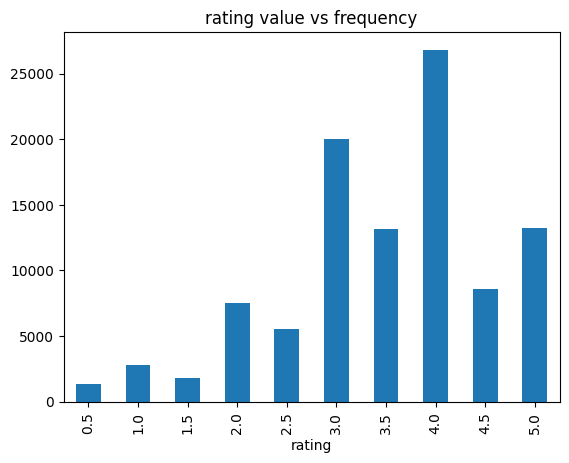

In [202]:
plt.title("rating value vs frequency")
rating_counts.plot(kind="bar")
plt.show()

# Data preprocessing

Surprise library creates internal IDS,
   - **Internal IDs/ Inner Ids:** These are the numeric IDs assigned by Surprise to users and items after the data is loaded into a Dataset object. These internal IDs are used internally by Surprise to index and manipulate the data. When you use these internal IDs, you typically work with Surprise-specific objects like Trainset and algorithms.

  - **Raw IDs:** These are the original IDs from your dataset, which could be strings, integers, or any other data type used to identify users and items in your actual data source.
  
To distinguish between the intern IDs and raw IDs, let's make some modification in our dataset.

In [203]:
# let's change moviesId from '<int>' to 'm_<int>' and similary userId from '<int>' to 'u_<int>'
movies_df['movieId'] = movies_df['movieId'].apply(lambda x: 'm_' + str(x))
ratings_df['movieId'] = ratings_df['movieId'].apply(lambda x: 'm_' + str(x))
ratings_df['userId'] = ratings_df['userId'].apply(lambda x: 'u_' + str(x))

In [204]:
movies_df.head()

,movieId,title,genres
0,m_1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,m_2,Jumanji (1995),Adventure|Children|Fantasy
2,m_3,Grumpier Old Men (1995),Comedy|Romance
3,m_4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,m_5,Father of the Bride Part II (1995),Comedy


In [205]:
movies_df[movies_df["title"] == "Saturn 3 (1980)"]

,movieId,title,genres
2141,m_2851,Saturn 3 (1980),Adventure|Sci-Fi|Thriller
9468,m_168358,Saturn 3 (1980),Sci-Fi|Thriller


It seem's same movies have different IDs, which is going to cause issue if not handled properly.

In [206]:
ratings_df.tail()

,userId,movieId,rating,timestamp
100831,u_610,m_166534,4.0,1493848402
100832,u_610,m_168248,5.0,1493850091
100833,u_610,m_168250,5.0,1494273047
100834,u_610,m_168252,5.0,1493846352
100835,u_610,m_170875,3.0,1493846415


# Data Loader

We have dataset in pandas dataframe, now to use surprise library built-in algorithms we have to convert it into Dataset object.

In [207]:
from surprise import Dataset, Reader

The **Reader** class in the Surprise library is used to specify how to read and parse your raw data into the **Dataset** object. It provides parameters that allow you to customize the way the data is formatted and loaded.

- **line_format:** This parameter defines the format of each line in your raw data file. It specifies the order of the data fields present in each line. For example, the line format is set to "user item rating timestamp", which means that each line in the data file should contain four fields: user ID, item ID, rating, and timestamp. other possible values "user item rating", "user item rating timestamp", "item user rating", "item rating user", "user rating item timestamp".

- **sep:** This parameter specifies the delimiter used to separate the fields in each line of your data file. In your example, it's set to ",", which means that the fields in each line are separated by commas.

- **skip_lines:** This parameter indicates the number of lines at the beginning of your data file to skip before starting to read the actual data. In your example, it's set to 1, which means that the first line (likely a header row) will be skipped, and the reading will start from the second line.

In [314]:
# let's create a reader object which we need to use for building Dataset object
# reader  = Reader(line_format="user item rating timestamp", sep=",", skip_lines=1)
reader  = Reader(rating_scale=(0.5, 5))

In [315]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,u_1,m_1,4.0,964982703
1,u_1,m_3,4.0,964981247
2,u_1,m_6,4.0,964982224
3,u_1,m_47,5.0,964983815
4,u_1,m_50,5.0,964982931


In [316]:
# creating a Dataset object
# It must have three columns, corresponding to the user (raw) ids, the item (raw) ids, and the ratings, in this order.
ratings_dataset =  Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader=reader)

In [317]:
ratings_dataset

Let's create a mapper that maps movie's name to the id. If you haven't forget yet, same movie have different IDs, so to handle it, let's add "_r_<index\>" redundant flag at the end of the movie name that has the same name.

In [318]:
# creating movie name to id mapper
movie_name_to_id = {}
for index, row in enumerate(movies_df.itertuples()):
    if not movie_name_to_id.get(row.title, None):
        movie_name_to_id[row.title] = row.movieId
    else:
        movie_name_to_id[row.title+f"_r_{index}"] = row.movieId

In [319]:
list(movie_name_to_id.items())[:10]

[('Toy Story (1995)', 'm_1'),
 ('Jumanji (1995)', 'm_2'),
 ('Grumpier Old Men (1995)', 'm_3'),
 ('Waiting to Exhale (1995)', 'm_4'),
 ('Father of the Bride Part II (1995)', 'm_5'),
 ('Heat (1995)', 'm_6'),
 ('Sabrina (1995)', 'm_7'),
 ('Tom and Huck (1995)', 'm_8'),
 ('Sudden Death (1995)', 'm_9'),
 ('GoldenEye (1995)', 'm_10')]

In [320]:
result = [(key, value) for key, value in movie_name_to_id.items() if key.startswith("Saturn 3 (1980)")]
result

[('Saturn 3 (1980)', 'm_2851'), ('Saturn 3 (1980)_r_9468', 'm_168358')]

Similarly, let's create a mapper that mapes movies' id to the name.

In [321]:
movie_id_to_name = {value: key for key, value in movie_name_to_id.items()}

In [322]:
list(movie_id_to_name.items())[:10]

[('m_1', 'Toy Story (1995)'),
 ('m_2', 'Jumanji (1995)'),
 ('m_3', 'Grumpier Old Men (1995)'),
 ('m_4', 'Waiting to Exhale (1995)'),
 ('m_5', 'Father of the Bride Part II (1995)'),
 ('m_6', 'Heat (1995)'),
 ('m_7', 'Sabrina (1995)'),
 ('m_8', 'Tom and Huck (1995)'),
 ('m_9', 'Sudden Death (1995)'),
 ('m_10', 'GoldenEye (1995)')]

In [323]:
movie_id_to_genre = {row.movieId: row.genres for row in movies_df.itertuples()}

In [324]:
movie_id_to_genre["m_1"]

'Adventure|Animation|Children|Comedy|Fantasy'

## Helper functions
Let's create some helpers function

In [325]:
def get_user_ratings(user_id, return_dataframe=False):
    """
    Retrieve movie ratings for a specific user.

    Parameters:
        user_id (int): The ID of the user for whom to retrieve ratings.
        return_dataframe (bool, optional): If True, returns the ratings as a DataFrame. 
            If False (default), returns the ratings as a list of lists.

    Returns:
        list or DataFrame: Depending on the value of return_dataframe, returns either a list of
        lists containing movie ID and rating pairs, or a DataFrame containing the same information.
    """
    if not return_dataframe:
        return list(ratings_df[ratings_df["userId"] == user_id][["movieId", "rating"]].values.tolist())
    return ratings_df[ratings_df["userId"] == user_id][["movieId", "rating"]] 

In [326]:
get_user_ratings("u_1", True)

,movieId,rating
0,m_1,4.0
1,m_3,4.0
2,m_6,4.0
3,m_47,5.0
4,m_50,5.0
...,...,...
227,m_3744,4.0
228,m_3793,5.0
229,m_3809,4.0
230,m_4006,4.0


In [327]:
def get_movie_name(movie_id):
    return movie_id_to_name[movie_id]

def get_movie_id(movie_name):
    return movie_name_to_id[movie_name]

def get_movie_genre(movie_id):
    return movie_id_to_genre[movie_id]

In [328]:
get_movie_name("m_5060")

'M*A*S*H (a.k.a. MASH) (1970)'

In [329]:
get_movie_id("Saturn 3 (1980)")

'm_2851'

In [330]:
get_movie_genre("m_5060")

'Comedy|Drama|War'

## Train/Test Split

Now, we have to split the dataset into train/test set, alternatively we can perform cross-validation also. For now, let's stick to the train/test split

In [331]:
from surprise.model_selection import train_test_split

In [332]:
train_set, test_set = train_test_split(ratings_dataset, test_size=0.2, random_state=1)

- `trainset:` This is a Trainset object which contains the training data that you'll use to train your recommendation model.
- `testset:` This is a list of tuples, each representing a user-item interaction in the testing set. Each tuple has the format (user_id, item_id, rating).

In [333]:
print("size of ratings in train set: ", train_set.n_ratings)
print("size of users in train set: ", train_set.n_users)
print("size of movies in train set: ", train_set.n_items)
print("size of test set: ", len(test_set))

size of ratings in train set:  80668
size of users in train set:  610
size of movies in train set:  8983
size of test set:  20168


In [334]:
test_set[:5]

[('u_469', 'm_2243', 4.0),
 ('u_187', 'm_49932', 4.0),
 ('u_399', 'm_589', 2.5),
 ('u_610', 'm_1394', 5.0),
 ('u_288', 'm_8965', 3.5)]

Let's see how surprise uses internal Ids instead of raw ids. Remember that raw ids have prefix of "u_" and "r_" in it.

In [335]:
print("Minimum and maximum rating: ", train_set.rating_scale)

Minimum and maximum rating:  (0.5, 5)


In [336]:
single_rating =  next(train_set.all_ratings())
print("internal user id: ", single_rating[0])
print("internal movie id: ", single_rating[1])
print("rating: ", single_rating[2])

internal user id:  0
internal movie id:  0
rating:  3.0


we can easily map this raw id to the inner id as well as internal id to the raw id.

In [337]:
# mapping internal user id 0 its corresponding raw user id
internal_uid = 0
print("Raw user Id: ", train_set.to_raw_uid(internal_uid))

Raw user Id:  u_225


In [338]:
# similarly we can perform reverse mapping
raw_uid = "u_225"
print("Raw user Id: ", train_set.to_inner_uid(raw_uid))

Raw user Id:  0


In [339]:
# same this can be done to the movies also
internal_iid = 0 #internal item id
print("Raw movie Id: ", train_set.to_raw_iid(internal_iid))

raw_iid = "m_380" #internal item id
print("inner movie Id: ", train_set.to_inner_iid(raw_iid))

Raw movie Id:  m_380
inner movie Id:  0


## User Vs Ratings visualization (before training)
let's visualize the user with their corresponding ratings, we are going to us heatmap for this visualization. 
It will help us to visualize the underlying distribution to the user to rating relationship.

First we have to create a matrix where each rows contain user_id and each columns contain movieid. Each cell contains user rating for corresponding movie.

In [340]:
def to_array(dataset):
    # since we have min rating value 0.5, we can use 0 to denote a absence of rating for a movie by particular user.
    user_rating_matrix = np.zeros((train_set.n_users, train_set.n_items))
    for (userId, movieId, rating) in dataset.all_ratings():
        user_rating_matrix[userId][movieId] = rating
    return user_rating_matrix

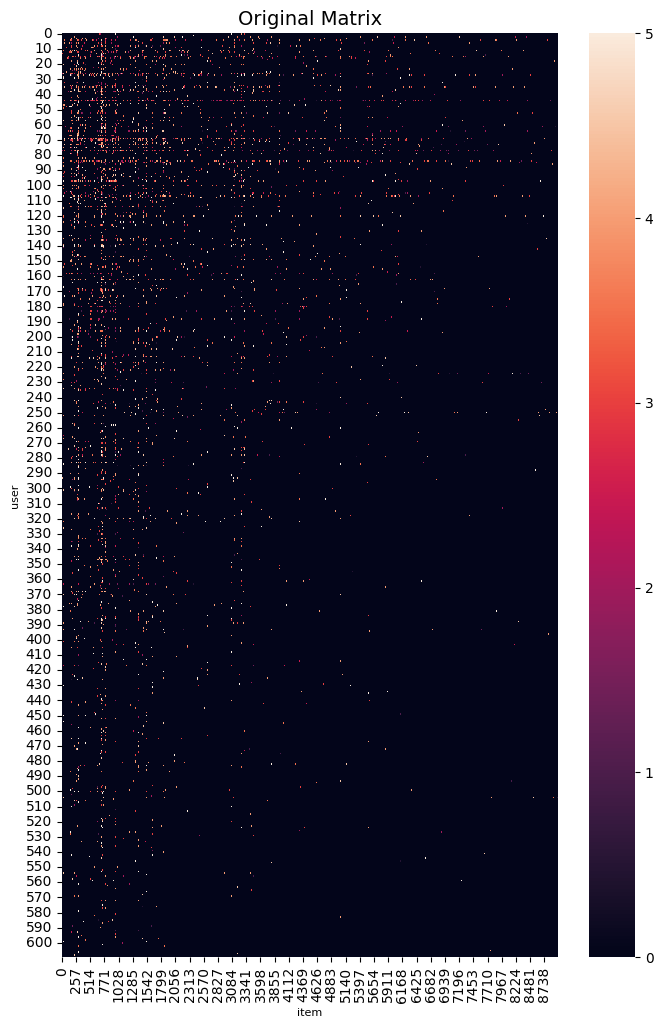

In [341]:
user_rating_matrix = to_array(train_set)
# Plot matrix
fig, ax = plt.subplots(figsize=(8, 12))
sns.heatmap(user_rating_matrix, ax=ax)
ax.set_title("Original Matrix", fontsize = 14)
ax.set_xlabel('item', fontsize = 8)
ax.set_ylabel('user', fontsize = 8)
plt.show()

Here dark regions represents absence of rating for the particular movie by the particular user.

# Algorithm Setup

- For this notebook, we are going to use only SVD (Singular Value Decomposition) algorithm to build a collaboration based recommendation system. Leter we will be working on building recommendation engine framework, where we can evaluate multiple algorithms. 
- If you are not familary with linear algebra and how SVD works, you can checkout the given links to get the intuition about how SVD works.
    - Linear algebra by khan academy: https://www.youtube.com/watch?v=aKhhYguY0DQ&list=PLFD0EB975BA0CC1E0
    - Essence of linear algebra: https://www.youtube.com/watch?v=fNk_zzaMoSs&list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab
    - Metrix visualization: https://www.youtube.com/watch?v=UyAfmAZU_WI
    - SVD and recommendation system: https://www.youtube.com/watch?v=rFemvJgXY7E
    - Dimensionality Reduction with SVD: https://www.youtube.com/watch?v=UyAfmAZU_WI


In [342]:
from surprise import SVD

Singular Value Decomposition (SVD) is a powerful mathematical technique that has found applications in various fields, including recommendation systems. In the context of recommendation systems, SVD is often used for collaborative filtering, which is a technique that predicts a user's preferences or recommendations by leveraging the preferences of other users.

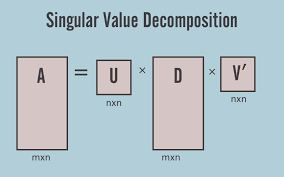

Here's how SVD can be applied to recommendation systems:

Singular Value Decomposition (SVD) can be employed in recommendation systems to make personalized recommendations based on user-item interactions. The process involves decomposing the user-item interaction matrix into three matrices that capture underlying patterns, and then using these matrices to predict missing values and generate recommendations. Here's a step-by-step explanation of how SVD works for recommendation systems:

1. **User-Item Interaction Matrix:** Consider a user-item interaction matrix where rows represent users, columns represent items, and the cells contain user ratings or interactions with items. However, this matrix is often sparse because users have not rated all items.

2. **SVD Decomposition:** SVD aims to factorize the user-item interaction matrix (A) into three matrices: U (user matrix), Σ (diagonal matrix of singular values), and V^T (item matrix transpose). Mathematically, this can be represented as A = UΣV^T. The dimensions of U and V^T are such that U has dimensions m x k (m = number of users, k = number of latent factors), Σ is a k x k diagonal matrix, and V^T has dimensions k x n (n = number of items).

3. **Dimensionality Reduction:** The key idea of SVD is to reduce the dimensionality of the original matrix by capturing latent factors. These latent factors represent hidden patterns that contribute to user preferences. The columns of U and V^T correspond to these latent factors. By selecting a smaller value for k (the rank of the factorization), you effectively reduce the dimensions of U and V^T matrices. This is important for dealing with sparsity and noise in the original user-item matrix.

4. **Matrix Reconstruction:** Once you have the U, Σ, and V^T matrices, you can reconstruct the original user-item interaction matrix by multiplying them: A_reconstructed = UΣV^T. The reconstructed matrix represents predicted ratings for all users and items.

5. **Prediction and Recommendation:** To make recommendations for a specific user, you focus on the row of the user in the reconstructed matrix. The missing values (items the user hasn't interacted with) in this row are filled with the predicted ratings. Higher predicted ratings indicate potential interest, and you can sort these predicted ratings to generate a list of recommended items for the user.

6. **Cold Start and New Data:** One challenge of SVD-based recommendation systems is the cold start problem, where new users or items have limited or no interactions. SVD struggles to provide recommendations for such cases, as it relies on historical interactions. In such scenarios, hybrid approaches that combine SVD with content-based recommendations or other techniques might be more effective.

7. **Regularization and Bias:** To improve the performance of SVD-based recommendation systems, regularization techniques can be applied to prevent overfitting. Additionally, bias terms can be incorporated to account for user and item biases, which can help capture nuances in user preferences and item popularity.

It's important to note that while SVD-based recommendation systems were popular in the past, more recent approaches like matrix factorization with neural networks and embeddings-based models have shown better performance due to their ability to capture complex patterns and handle large-scale data more effectively.

The SVD has a lot of parameters. The most important ones are:
- `n_factors`, which controls the dimension of the latent space (i.e. the size of the vectors and ). Usually, the quality of the training set predictions grows with as n_factors gets higher.
- `n_epochs`, which defines the number of iteration of the SGD procedure.

In [343]:
svd_model = SVD(random_state=10, n_factors=100, n_epochs=50, verbose=False)

In [344]:
# training our SVD_model
svd_model.fit(train_set)

let's make predictions on testset

In [345]:
test_predictions = svd_model.test(test_set)

In [346]:
test_predictions[:10]

[Prediction(uid='u_469', iid='m_2243', r_ui=4.0, est=3.575230748230819, details={'was_impossible': False}),
 Prediction(uid='u_187', iid='m_49932', r_ui=4.0, est=3.8755148279179297, details={'was_impossible': False}),
 Prediction(uid='u_399', iid='m_589', r_ui=2.5, est=4.149344437752052, details={'was_impossible': False}),
 Prediction(uid='u_610', iid='m_1394', r_ui=5.0, est=4.206949457133889, details={'was_impossible': False}),
 Prediction(uid='u_288', iid='m_8965', r_ui=3.5, est=2.6272256455456664, details={'was_impossible': False}),
 Prediction(uid='u_182', iid='m_6890', r_ui=4.5, est=3.743625822569279, details={'was_impossible': False}),
 Prediction(uid='u_357', iid='m_3481', r_ui=3.0, est=4.040048250140339, details={'was_impossible': False}),
 Prediction(uid='u_202', iid='m_2628', r_ui=4.0, est=2.8193719943639133, details={'was_impossible': False}),
 Prediction(uid='u_600', iid='m_1348', r_ui=2.5, est=3.5159314760051723, details={'was_impossible': False}),
 Prediction(uid='u_249',

Let's break down the different components of this prediction `Prediction(uid='469', iid='2243', r_ui=4.0, est=3.5778806340563234, details={'was_impossible': False})`:

- **uid:** This is the user ID for which the prediction was made. In this case, the user ID is '469'.

- **iid:** This is the item ID for which the prediction was made. In this case, the item ID is '2243'.

- **r_ui:** This is the actual rating that the user with ID '469' gave to the item with ID '2243'. In this prediction result, the actual rating is 4.0.

- **est:** This is the estimated or predicted rating that the recommendation algorithm provided for the user-item combination ('469', '2243'). The estimated rating is approximately 3.5779.

- **details:** This is a dictionary that provides additional information about the prediction. In this case, the key **'was_impossible'** is `False`, indicating that the prediction was possible and not flagged as impossible by the algorithm. This is useful when dealing with cases where the algorithm couldn't provide a prediction due to certain conditions not being met.


## User Vs Ratings visualization (after training)

You can find the information about this factors and bias terms (pu, qi..) in the official documentation: https://surprise.readthedocs.io/en/stable/matrix_factorization.html

In [347]:
#  User factors; shape (n_user, n_factors)
pu = svd_model.pu
pu.shape

(610, 100)

<Axes: >

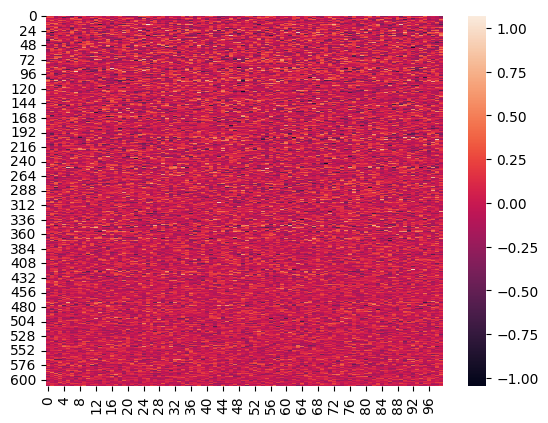

In [348]:
sns.heatmap(pu)

<Axes: >

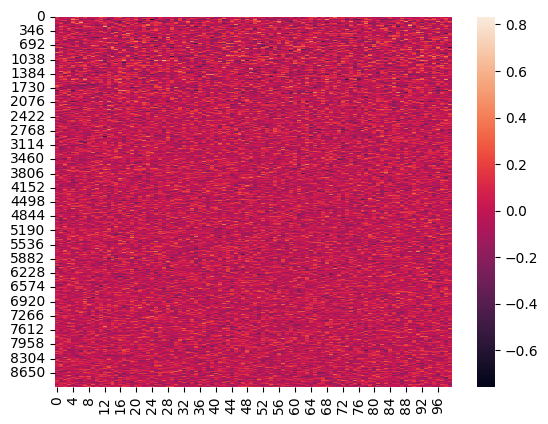

In [349]:
# Items factors; shape (n_items, n_factors)
qi =svd_model.qi
sns.heatmap(qi)

### Reconstruction formula
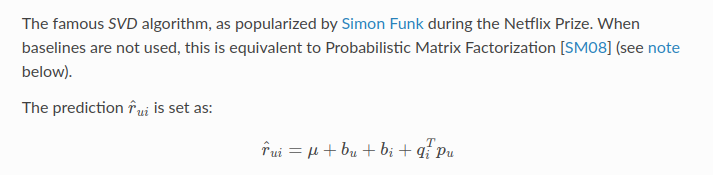

In [350]:
# user biases ; shape (n_users)
bu = svd_model.bu.reshape(svd_model.bu.shape[0], 1)

# item biases; shape (n_items)
bi = svd_model.bi.reshape(svd_model.bi.shape[0], 1)

# Reconstruction of original matrix
mean = train_set.global_mean
# implementation of above formula
reconstruct = mean + bu + bi.T + (pu).dot((qi).T)

print("Shape of reconstructed matrix: ", reconstruct.shape)
print("Number of users: ", reconstruct.shape[0])
print("Number of movies: ", reconstruct.shape[1])

Shape of reconstructed matrix:  (610, 8983)
Number of users:  610
Number of movies:  8983


<Axes: title={'center': 'user_vs_items rating matrix (prediction matrix)'}>

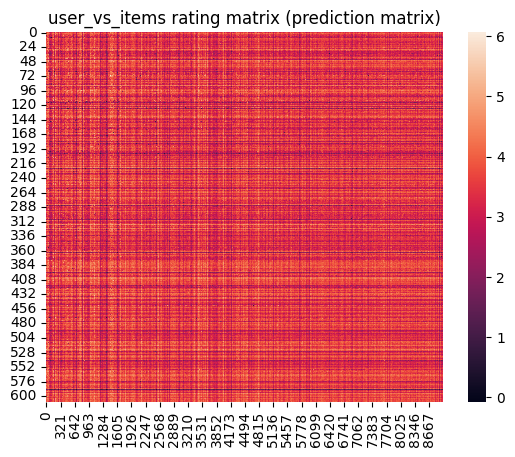

In [351]:
plt.title("user_vs_items rating matrix (prediction matrix)")
sns.heatmap(reconstruct)

Here you can see, the ranks are greater than 5 and less than 0.5, we have to do some adjustment.

<Axes: >

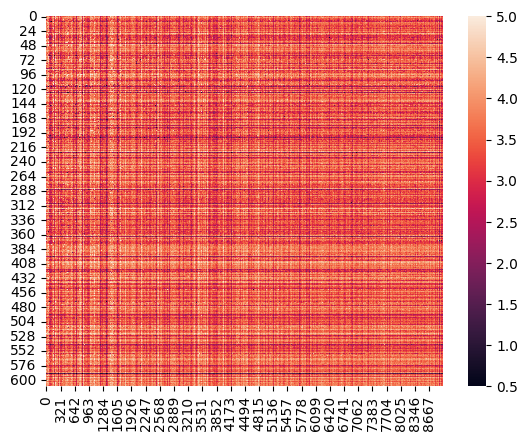

In [352]:
# cliping the value greater than 5 and less than 0.5
reconstruct = np.clip(reconstruct, 0.5, 5)
sns.heatmap(reconstruct)

### Comparision between original and predicted
We are going to see how much changes are there in the known ratings, rather than the unknown one.

<Axes: >

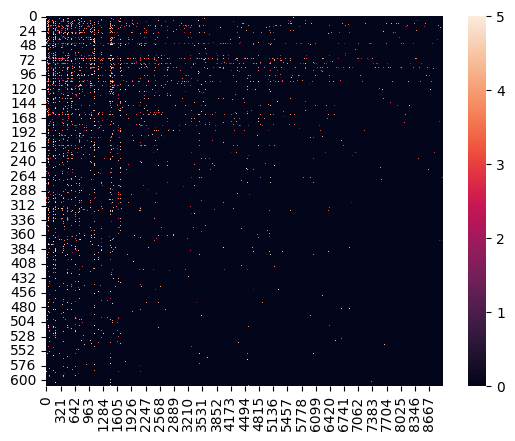

In [353]:
unknown_ratings = (user_rating_matrix == 0)
# setting previously unknown ratings to zero
reconstruct[unknown_ratings] = 0

sns.heatmap(reconstruct)

<Axes: title={'center': 'absolute differnce between origin and predicted matrix in the known ratings'}>

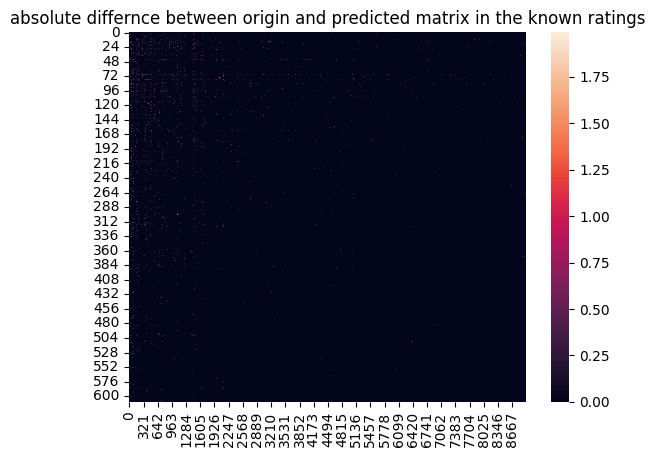

In [354]:
# Get diff matrix
diff_matrix = np.abs(user_rating_matrix - reconstruct)

plt.title("absolute differnce between origin and predicted matrix in the known ratings")
sns.heatmap(diff_matrix)

Upon looking this heatmap, we can say that there is not much changes in the origin ratings by the user.

## Evaluation

You can checkout the my another notebook (you can find it in`Evaluation Metrics` directory) where I have described various evaluation metrics.

In [355]:
from surprise import accuracy

## Computing Accuracy

### MAE
source: https://surprise.readthedocs.io/en/stable/_modules/surprise/accuracy.html#mae

*Note that in test_predictions each item has both actual and estimated rating values, since it is compute to the test set where actual is available* 

In [403]:
mae = accuracy.mae(test_predictions, verbose=False)
print("Mean absolute error: ", mae)

Mean absolute error:  0.6756898517263134


### RMSE

In [405]:
rmse = accuracy.rmse(test_predictions, verbose=False)
print("Root Mean Square: ", rmse)

Root Mean Square:  0.8827496011299856


# Evaluate top-10 with Leave One Out testing

- Leave-one-out cross-validation is a common technique used to assess the performance of recommendation algorithms.
- Leave-one-out cross-validation involves systematically leaving out one data point (in this case, one user-item interaction) from the dataset and using the remaining data to train a recommendation model. The model is then evaluated by predicting the left-out data point and comparing the prediction to the actual value. This process is repeated for each data point in the dataset.
- **Cross-validation iterator where each user has exactly one rating in the testset.**

In [358]:
from surprise.model_selection import LeaveOneOut

In [359]:
ratings_dataset

- `n_splits` specifies the number of splits or folds to create in the dataset for the purpose of validation. Each split consists of a training set and a validation (test) set. n_splits determines how many times the dataset is divided into these splits, and the model is trained and evaluated accordingly.

In [360]:
# recalling our dataset
print("Total movies : ", len(movies_df))
print("Total ratings: ", len(ratings_df))
print("Total users: ", len(ratings_df["userId"].unique()))

Total movies :  9742
Total ratings:  100836
Total users:  610


LelaveOneOut source: https://surprise.readthedocs.io/en/stable/_modules/surprise/model_selection/split.html#LeaveOneOut

In [361]:
LOOCV = LeaveOneOut(n_splits=1, random_state=1)
for i, (train, test) in enumerate(LOOCV.split(ratings_dataset)):
    LOOCV_trainset = train
    LOOCV_testset = test
    print(i)

0


- `build_anti_trainset`: generates a set of user-item interactions that are not present in the training set (anti-testset).
- The ratings are all the ratings that are not in the trainset, i.e. all the ratings where the user is known, the item is known, but the rating is not in the trainset. 

In [387]:
anti_testset = LOOCV_trainset.build_anti_testset()

In [363]:
test_users = len(pd.DataFrame(LOOCV_testset)[0].unique())

610

In [388]:
print("Total users in train: ",LOOCV_trainset.n_users)
print("Total ratings in train/ total rows: ", LOOCV_trainset.n_ratings)
print("Total ratings in test: ", len(LOOCV_testset))
print("Total users in test: ", test_users)
print("Size of anti-testset: ", len(anti_testset))

Total users in train:  610
Total ratings in train/ total rows:  100226
Total ratings in test:  610
Total users in test:  610
Size of anti-testset:  5822264


- We had 100836 rows in total, now we have 100226 rows in our train set, the remaining 100836 - 100226 = 610, rows are in our test set.
- Similar, test set have 610 users, which is the total users on our dataset, so we can conclude that train set has exactly one rating of each user. 

In [375]:
# model traing
svd_model_LO = SVD(random_state=10, n_factors=100, n_epochs=50, verbose=False)
svd_model_LO.fit(LOOCV_trainset)

In [376]:
LO_predictions = svd_model_LOU.test(LOOCV_testset)

In [396]:
print("First 10 predictions: ")
LO_predictions[:10]

First 10 predictions: 


[Prediction(uid='u_1', iid='m_648', r_ui=3.0, est=4.586604275743432, details={'was_impossible': False}),
 Prediction(uid='u_2', iid='m_71535', r_ui=3.0, est=3.8013229099178605, details={'was_impossible': False}),
 Prediction(uid='u_3', iid='m_1302', r_ui=0.5, est=2.163082364019499, details={'was_impossible': False}),
 Prediction(uid='u_4', iid='m_1136', r_ui=5.0, est=4.367405490572386, details={'was_impossible': False}),
 Prediction(uid='u_5', iid='m_153', r_ui=3.0, est=2.6339820983628695, details={'was_impossible': False}),
 Prediction(uid='u_6', iid='m_460', r_ui=3.0, est=3.423456506347957, details={'was_impossible': False}),
 Prediction(uid='u_7', iid='m_33794', r_ui=2.0, est=4.112335756645776, details={'was_impossible': False}),
 Prediction(uid='u_8', iid='m_208', r_ui=3.0, est=2.5734002154893902, details={'was_impossible': False}),
 Prediction(uid='u_9', iid='m_41', r_ui=3.0, est=3.5644436097027254, details={'was_impossible': False}),
 Prediction(uid='u_10', iid='m_109374', r_ui=0

In [377]:
anti_test_predictions = svd_model_LO.test(anti_testset)

In [414]:
print("First 10 anti_testset: ")
anti_testset[:10]

First 10 anti_testset: 


[('u_1', 'm_318', 3.5004639514696785),
 ('u_1', 'm_1704', 3.5004639514696785),
 ('u_1', 'm_6874', 3.5004639514696785),
 ('u_1', 'm_8798', 3.5004639514696785),
 ('u_1', 'm_46970', 3.5004639514696785),
 ('u_1', 'm_48516', 3.5004639514696785),
 ('u_1', 'm_58559', 3.5004639514696785),
 ('u_1', 'm_60756', 3.5004639514696785),
 ('u_1', 'm_68157', 3.5004639514696785),
 ('u_1', 'm_74458', 3.5004639514696785)]

Note that when we create anti_testset, the method build_anti_testset() internally fills the actual rating even though anti_testset don't have any actual ratings by the user. https://surprise.readthedocs.io/en/stable/_modules/surprise/trainset.html#Trainset.build_anti_testset

In [412]:
print("First 10 antitest predictions")
anti_test_predictions[:10]

First 10 antitest predictions


[Prediction(uid='u_1', iid='m_318', r_ui=3.5004639514696785, est=5, details={'was_impossible': False}),
 Prediction(uid='u_1', iid='m_1704', r_ui=3.5004639514696785, est=4.722457261753707, details={'was_impossible': False}),
 Prediction(uid='u_1', iid='m_6874', r_ui=3.5004639514696785, est=4.528335195296247, details={'was_impossible': False}),
 Prediction(uid='u_1', iid='m_8798', r_ui=3.5004639514696785, est=4.07393104569615, details={'was_impossible': False}),
 Prediction(uid='u_1', iid='m_46970', r_ui=3.5004639514696785, est=3.9175726063713405, details={'was_impossible': False}),
 Prediction(uid='u_1', iid='m_48516', r_ui=3.5004639514696785, est=4.783852784574227, details={'was_impossible': False}),
 Prediction(uid='u_1', iid='m_58559', r_ui=3.5004639514696785, est=4.887931746825141, details={'was_impossible': False}),
 Prediction(uid='u_1', iid='m_60756', r_ui=3.5004639514696785, est=4.302528100607678, details={'was_impossible': False}),
 Prediction(uid='u_1', iid='m_68157', r_ui=3.

### Get top N predictions

In [410]:
# this function returns top n predicted ratings associated with each user
def get_top_n_predictions(prediction, n=10, min_rating=0.3):
    top_n = defaultdict(list)
    
     # Organize predictions by user
    for (user_id, movie_id, actual_rating, est_rating, _) in prediction:
        if est_rating >= min_rating: # Apply rating threshold
            top_n[user_id].append((movie_id, est_rating))
    
    # Sort and get top n predicted ratings for each user
    for user_id, ratings in top_n.items():
        ratings.sort(key = lambda kv: kv[1], reverse=True)
        top_n[user_id] = ratings[:n] 
    return top_n

In [411]:
# now we have top 10 predicted ratings of each user
top_n_ratings = get_top_n_predictions(anti_test_predictions)
list(top_n_ratings.items())[:2]

[('u_1',
  [('m_318', 5),
   ('m_74458', 5),
   ('m_77455', 5),
   ('m_79132', 5),
   ('m_80906', 5),
   ('m_109487', 5),
   ('m_112552', 5),
   ('m_720', 5),
   ('m_2288', 5),
   ('m_247', 5)]),
 ('u_2',
  [('m_951', 4.636891452144927),
   ('m_1945', 4.590273719972855),
   ('m_858', 4.558199597153344),
   ('m_1225', 4.5479062903786955),
   ('m_2360', 4.523222095245376),
   ('m_87234', 4.499157986015936),
   ('m_8132', 4.498042776190348),
   ('m_265', 4.497322590081566),
   ('m_51931', 4.4938009542131),
   ('m_3814', 4.490559913232129)])]

Note that these movies and ratings haven't been rated by the corresponding user yet. These are the estimated ratings for the movies that the users may rate.

### Hit rate

Let’s see how good our top-10 recommendations are. To evaluate top-10, we use hit rate, that is, if a user rated one of the top-10 we recommended, we consider it is a “hit”.

- Most of the online resource uses the approach used in this [article](https://towardsdatascience.com/evaluating-a-real-life-recommender-system-error-based-and-ranking-based-84708e3285b) to compute hit
- One of the limitation of their approach is they are trying to expect hit (lies within top n recommendation list) event though the movie have actual bad rating by the user.

- Instead of that we are going to make slidly modification to ensure that while computing hit we compare the movie that has rating >= lower_threshold, else the movie won't have any contribution while computing hit.

In [380]:
top_n_ratings["u_2"]

[('m_951', 4.636891452144927),
 ('m_1945', 4.590273719972855),
 ('m_858', 4.558199597153344),
 ('m_1225', 4.5479062903786955),
 ('m_2360', 4.523222095245376),
 ('m_87234', 4.499157986015936),
 ('m_8132', 4.498042776190348),
 ('m_265', 4.497322590081566),
 ('m_51931', 4.4938009542131),
 ('m_3814', 4.490559913232129)]

In [432]:
def hit_rate(top_n_ratings, left_out_predictions):
    hits = 0
    total = 0
    for items in left_out_predictions:
        lo_user_id = items[0]
        lo_movie_id = items[1]
        
        # ignore left_out_predictions of those user-move that has rating less than 4.
        # we are making assumption here any movie that the user has rated greater than 4, is relevant.
        # and thus should have recommended by the model
        if items[3] <= 4.0:
            continue
            
        hit = False
        for m_id, est in top_n_ratings[lo_user_id]:
            if m_id == lo_movie_id: # hit
                hits += 1
                break
        total += 1
        
    return hits/total, hits, total

In [433]:
hit_rate(top_n_ratings, LO_predictions)

(0.11267605633802817, 24, 213)

It seems we have got 11% hit rate, which is not that good, may be because of the size of our dataset. Or could be the limitation of SVD model. 

## Predictions

In [78]:
movie_id_user_2 = list(ratings_df[ratings_df["userId"]=="u_2"]["movieId"].unique())
print("Movies that user_2 has rated: ", movie_id_user_2)

Movies that user_2 has rated:  ['m_318', 'm_333', 'm_1704', 'm_3578', 'm_6874', 'm_8798', 'm_46970', 'm_48516', 'm_58559', 'm_60756', 'm_68157', 'm_71535', 'm_74458', 'm_77455', 'm_79132', 'm_80489', 'm_80906', 'm_86345', 'm_89774', 'm_91529', 'm_91658', 'm_99114', 'm_106782', 'm_109487', 'm_112552', 'm_114060', 'm_115713', 'm_122882', 'm_131724']


In [95]:
user_id = 'u_1'
movie_id = 'm_1'
predicted_rating = svd_model.predict(user_id, movie_id)
print("predicted ratings", predicted_rating.est)

predicted ratings 4.320205950075643


In [96]:
# let's check the prediction for user 2 for the movie that he haven't rated yet
user_id = 'u_2'
movie_id = 'm_50'
predicted_rating = svd_model.predict(user_id, movie_id) #it supposed to predict 5
predicted_rating

Prediction(uid='u_2', iid='m_50', r_ui=None, est=4.047239430102093, details={'was_impossible': False})

Here you can see r_ui is None, means users haven't rated this movie yet.

In [97]:
# user rating for the movie that are not in the training set
user_id = "u_2"
movie_id = "m_1000000000"
predicted_rating = svd_model.predict(user_id, movie_id) #it supposed to predict 5
predicted_rating

Prediction(uid='u_2', iid='m_1000000000', r_ui=None, est=3.5412267993757007, details={'was_impossible': False})

# recommending top N movies

Now, we are going to recommend top N movies to a user which hasn't been recommended by the user yet.

In [87]:
from collections import defaultdict

In [94]:
print("Total number of movies in train_set: ", train_set.n_items)

Total number of movies in train_set:  8983


In [92]:
# trainset = ratings_dataset.build_full_trainset()
# print(trainset.n_users, trainset.n_items)

610 9724


In [257]:
# creating a decorator to wrap the result into dataframe
def to_dataframe(columns):
    def decorator(func):
        def wrapper(*args, **kwargs):
            result = func(*args, **kwargs)
            df = pd.DataFrame(result, columns=columns)
            return df
        return wrapper
    return decorator

Alternatively, you can directly put pd.DataFrame inside that function. I wanted to see how we can create custom decorator. 

In [263]:
# returns the name of top n movie user has rated, 
# we can use this information to directly compare the quality of recommendation to that user
@to_dataframe(columns=["movieId", "movie name", "actual rating" ,"genre"])
def get_top_n_ratings(user_id, n=10):
    top_n = []
    df_slice_by_user = ratings_df[ratings_df.userId == user_id]

    for row in df_slice_by_user.itertuples():
        top_n.append((row.movieId, get_movie_name(row.movieId), row.rating, get_movie_genre(row.movieId)))
    top_n.sort(key= lambda kv:kv[2], reverse=True)
    return top_n[:n]

In [267]:
print("User top 10 ratings")
get_top_n_ratings("u_1")

User top 10 ratings


,movieId,movie name,actual rating,genre
0,m_47,Seven (a.k.a. Se7en) (1995),5.0,Mystery|Thriller
1,m_50,"Usual Suspects, The (1995)",5.0,Crime|Mystery|Thriller
2,m_101,Bottle Rocket (1996),5.0,Adventure|Comedy|Crime|Romance
3,m_151,Rob Roy (1995),5.0,Action|Drama|Romance|War
4,m_157,Canadian Bacon (1995),5.0,Comedy|War
5,m_163,Desperado (1995),5.0,Action|Romance|Western
6,m_216,Billy Madison (1995),5.0,Comedy
7,m_231,Dumb & Dumber (Dumb and Dumber) (1994),5.0,Adventure|Comedy
8,m_260,Star Wars: Episode IV - A New Hope (1977),5.0,Action|Adventure|Sci-Fi
9,m_333,Tommy Boy (1995),5.0,Comedy


In [448]:
@to_dataframe(columns=["movieId", "movie name", "estimated rating" ,"genre"])
def get_top_n_recommendations(user_id, n=10, minimum_ratings=3.0):
    top_n = top_n_ratings[user_id]
    return [(movie_id, get_movie_name(movie_id), rating, get_movie_genre(movie_id))
            for movie_id, rating in top_n]

In [449]:
print("Top 10 recommendation for the user: ")
get_top_n_recommendations("u_1")

Top 10 recommendation for the user: 


,movieId,movie name,estimated rating,genre
0,m_318,"Shawshank Redemption, The (1994)",5,Crime|Drama
1,m_74458,Shutter Island (2010),5,Drama|Mystery|Thriller
2,m_77455,Exit Through the Gift Shop (2010),5,Comedy|Documentary
3,m_79132,Inception (2010),5,Action|Crime|Drama|Mystery|Sci-Fi|Thriller|IMAX
4,m_80906,Inside Job (2010),5,Documentary
5,m_109487,Interstellar (2014),5,Sci-Fi|IMAX
6,m_112552,Whiplash (2014),5,Drama
7,m_720,Wallace & Gromit: The Best of Aardman Animatio...,5,Adventure|Animation|Comedy
8,m_2288,"Thing, The (1982)",5,Action|Horror|Sci-Fi|Thriller
9,m_247,Heavenly Creatures (1994),5,Crime|Drama


## Checking the recommendation for user_2

In [455]:
print("User top 10 ratings")
get_top_n_ratings("u_20")

User top 10 ratings


,movieId,movie name,actual rating,genre
0,m_48,Pocahontas (1995),5.0,Animation|Children|Drama|Musical|Romance
1,m_364,"Lion King, The (1994)",5.0,Adventure|Animation|Children|Drama|Musical|IMAX
2,m_551,"Nightmare Before Christmas, The (1993)",5.0,Animation|Children|Fantasy|Musical
3,m_588,Aladdin (1992),5.0,Adventure|Animation|Children|Comedy|Musical
4,m_594,Snow White and the Seven Dwarfs (1937),5.0,Animation|Children|Drama|Fantasy|Musical
5,m_595,Beauty and the Beast (1991),5.0,Animation|Children|Fantasy|Musical|Romance|IMAX
6,m_661,James and the Giant Peach (1996),5.0,Adventure|Animation|Children|Fantasy|Musical
7,m_720,Wallace & Gromit: The Best of Aardman Animatio...,5.0,Adventure|Animation|Comedy
8,m_919,"Wizard of Oz, The (1939)",5.0,Adventure|Children|Fantasy|Musical
9,m_1025,"Sword in the Stone, The (1963)",5.0,Animation|Children|Fantasy|Musical


In [456]:
print("Top 10 recommendation for the user: ")
get_top_n_recommendations('u_20')

Top 10 recommendation for the user: 


,movieId,movie name,estimated rating,genre
0,m_260,Star Wars: Episode IV - A New Hope (1977),5,Action|Adventure|Sci-Fi
1,m_923,Citizen Kane (1941),5,Drama|Mystery
2,m_1196,Star Wars: Episode V - The Empire Strikes Back...,5,Action|Adventure|Sci-Fi
3,m_1197,"Princess Bride, The (1987)",5,Action|Adventure|Comedy|Fantasy|Romance
4,m_2571,"Matrix, The (1999)",5,Action|Sci-Fi|Thriller
5,m_912,Casablanca (1942),5,Drama|Romance
6,m_1203,12 Angry Men (1957),5,Drama
7,m_2019,Seven Samurai (Shichinin no samurai) (1954),5,Action|Adventure|Drama
8,m_290,Once Were Warriors (1994),5,Crime|Drama
9,m_293,Léon: The Professional (a.k.a. The Professiona...,5,Action|Crime|Drama|Thriller


It seems it gave pretty descent result.

# What next?
- build a python package, what contains data loader, model evaluator, and overall recommendation system framework, that allow us to evaluate multiple model simultaneously.